In [1]:
# --- Imports
import numpy as np
import matplotlib.pyplot as plt

from moosbi import (
    IndependentParameter,
    ParameterBank,
    make_ou_example,
    optimize_with_pymoo,
)


In [ ]:
# --- Ground-truth (for generating targets to fit)
theta_true = 1.2
mu_true = 0.5
sigma_true = 0.8

# Simulation controls
T = 10.0
dt = 1e-3
burn_in = 500
x0 = mu_true
print(f"After burnin, trace will have {int(T / dt)} points. 1/sqrt({int(T / dt)}) = {1/np.sqrt(T/dt)}")

# Derived targets for objectives (stationary approximations)
target_mean = mu_true
target_var = sigma_true**2 / (2.0 * theta_true)
target_ac1 = float(np.exp(-theta_true * dt))  # approx for small dt


After burnin, trace will have 10000 points


In [3]:
# --- Build ParameterBank
# Note: fixed parameters use IndependentParameter(value) only.
bank = ParameterBank(
    parameters={
        # Sampled model parameters (with reasonable bounds)
        "theta": IndependentParameter(theta_true, is_sampled=True, range=(0.1, 3.0)),
        "mu":    IndependentParameter(mu_true,    is_sampled=True, range=(-1.0, 1.0)),
        "sigma": IndependentParameter(sigma_true, is_sampled=True, range=(0.1, 2.0)),

        # Fixed simulation controls
        "T":       IndependentParameter(T),
        "dt":      IndependentParameter(dt),
        "burn_in": IndependentParameter(burn_in),
        "x0":      IndependentParameter(x0),

        # Fixed targets (objectives compare output stats to these)
        "target_mean": IndependentParameter(target_mean),
        "target_var":  IndependentParameter(target_var),
        "target_ac1":  IndependentParameter(target_ac1),
    },
    theta_sampling=True,  # decision vector includes only sampled parameters
)


In [ ]:
# --- Create Simulator (aggregate objectives across seeds for robustness)
seeds = [0, 1, 2, 3]
sim = make_ou_example(bank, seeds=seeds)

# --- Run multi-objective optimization (NSGA-II)
res = optimize_with_pymoo(
    simulator=sim,
    pop_size=80,          # adjust for speed/quality
    n_gen=100,             # adjust for speed/quality
    seed=123,
    aggregate_mode="mean",  # mean/median/max/cvar
    cvar_alpha=0.2,
    verbose=True,
)

X = res["X"]       # decision vectors (sampled params only)
F = res["F"]       # objective matrix: [MSE_mean, MSE_var, MSE_ac1]
params_list = res["params"]  # corresponding full ParameterSet objects


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       80 |     13 |             - |             -
     2 |      160 |     18 |  0.0209338338 |         ideal
     3 |      240 |     28 |  0.0043862606 |         ideal
     4 |      320 |     37 |  0.0315910052 |         nadir
     5 |      400 |     58 |  0.0281503402 |             f
     6 |      480 |     80 |  0.0127612191 |         nadir
     7 |      560 |     80 |  0.0104975690 |         ideal
     8 |      640 |     80 |  0.0123301666 |         nadir
     9 |      720 |     80 |  0.0792573967 |         nadir
    10 |      800 |     80 |  0.2465287480 |         nadir
    11 |      880 |     80 |  0.1325245107 |         nadir
    12 |      960 |     80 |  0.0147255144 |             f
    13 |     1040 |     80 |  0.0197590564 |             f
    14 |     1120 |     80 |  0.2357468842 |         nadir
    15 |     1200 |     80 |  0.0047977470 |         nadir
    16 |     1280 |     80 |  0.0155409569 |            

In [ ]:
# --- Extract recovered parameter arrays from Pareto set
theta_rec = np.array([float(p["theta"]) for p in params_list])
mu_rec    = np.array([float(p["mu"])    for p in params_list])
sigma_rec = np.array([float(p["sigma"]) for p in params_list])

# --- Select a simple "best" (optional): min sum of objectives over Pareto set
best_idx = int(np.argmin(F.sum(axis=1)))
best_params = params_list[best_idx]

print("Best params (min sum of objectives):")
print({k: float(best_params[k]) for k in ["theta", "mu", "sigma"]})
print("True params:", {"theta": theta_true, "mu": mu_true, "sigma": sigma_true})
print("Objectives @best:", F[best_idx].tolist())



Best params (min sum of objectives):
{'theta': 2.989935714879233, 'mu': 0.5847303844976119, 'sigma': 0.6142285652324753}
True params: {'theta': 1.2, 'mu': 0.5, 'sigma': 0.8}
Objectives @best: [0.017244407638942277, 0.04583911693112682, 8.079662254338545e-06]


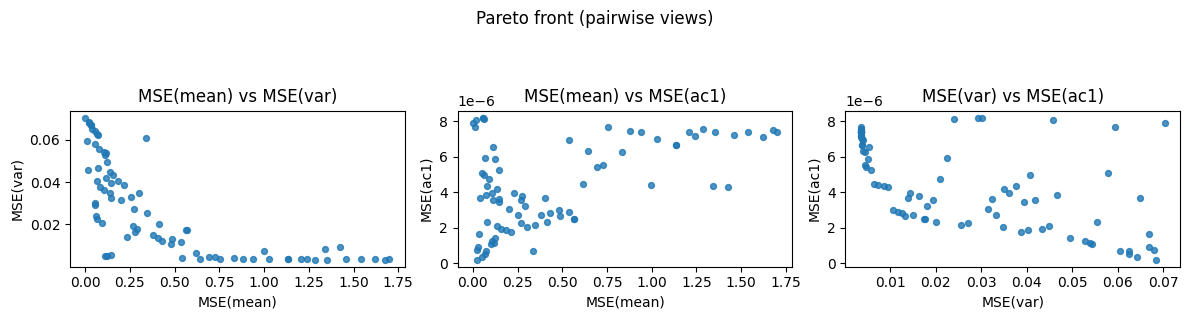

In [ ]:
# --- Plot: Pareto front (pairwise)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pairs = [(0, 1), (0, 2), (1, 2)]
labels = ["MSE(mean)", "MSE(var)", "MSE(ac1)"]
for ax, (i, j) in zip(axes, pairs):
    ax.scatter(F[:, i], F[:, j], s=18, alpha=0.8)
    ax.set_xlabel(labels[i])
    ax.set_ylabel(labels[j])
    ax.set_title(f"{labels[i]} vs {labels[j]}")
fig.suptitle("Pareto front (pairwise views)", y=1.05)
plt.tight_layout()
plt.show()



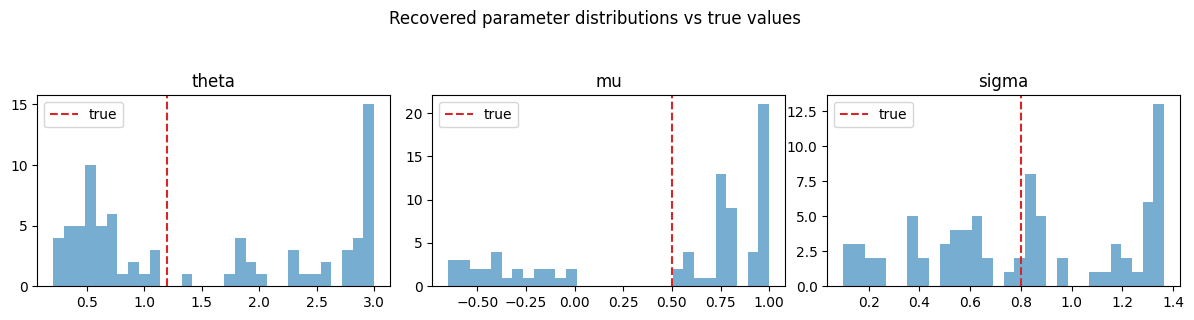

In [ ]:
# --- Plot: recovered parameter distributions vs true values
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(theta_rec, bins=30, color="C0", alpha=0.6)
axes[0].axvline(theta_true, color="C3", linestyle="--", label="true")
axes[0].set_title("theta")
axes[0].legend()

axes[1].hist(mu_rec, bins=30, color="C0", alpha=0.6)
axes[1].axvline(mu_true, color="C3", linestyle="--", label="true")
axes[1].set_title("mu")
axes[1].legend()

axes[2].hist(sigma_rec, bins=30, color="C0", alpha=0.6)
axes[2].axvline(sigma_true, color="C3", linestyle="--", label="true")
axes[2].set_title("sigma")
axes[2].legend()

fig.suptitle("Recovered parameter distributions vs true values", y=1.05)
plt.tight_layout()
plt.show()